# Planify - Graph Neural Network

### Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
    <ul>
        <li><a href="#Imports">Imports</a></li>
        <li><a href="#func">Functions used</a></li>
    </ul>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#model">GNN Model</a></li>
    <ul>
        <li><a href="#dataLoader">Data Loader</a></li>
        <li><a href="#archi">Architecture</a></li>
        <li><a href="#train">Training</a></li> 
        <li><a href="#eval">Evaluation</a></li>
    </ul>
</ul>

<a id='intro'></a>
## Introduction

> This notebook getting garphs in the Networkx format from the `Creating Graphs` notebook. And its main goal is to make the GNN model.

In [3]:
# Used for vsCode only to show tqdm process
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

<a id='Imports'></a>
### Imports

In [4]:
# Only for kaggle
# !pip install torch_geometric

In [5]:
# Not included packages in kaggle

# Install torch_geometric
# !pip install /kaggle/input/torch-geometric/torch_sparse-0.6.16-cp37-cp37m-linux_x86_64.whl -q
# !pip install /kaggle/input/torch-geometric/torch_scatter-2.1.0-cp37-cp37m-linux_x86_64.whl -q

# # # library for getting distinct colores
!pip install distinctipy -q

In [1]:
# for data wrangling
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import distinctipy
import random
from torch_geometric.utils import from_networkx

# to show advance in for loops
from tqdm import tqdm

# Using pytorch geometric
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, Batch
from torch.utils.data import Dataset
import torch_geometric.transforms as T


# For the GNN model
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, global_max_pool


# for my pc [linux]
# url = '/media/mo/DATA/Grad/Planify_Dataset/Graph/Planify_Graphs.pkl'

# for my pc [windows]
url = "D:\Grad\Planify_Dataset\Graph\Planify_Graphs.pkl"

# for kaggle
# url = '/kaggle/input/planify-graphs/Planify_Graphs.pkl'

<a id='func'></a>
### Functions used

In [2]:
geoms_columns = ['inner', 'living', 'master', 'kitchen', 'bathroom', 'dining', 'child', 'study',
                   'second_room', 'guest', 'balcony', 'storage', 'wall-in',
                    'outer_wall', 'front', 'inner_wall', 'interior',
                   'front_door', 'outer_wall', 'entrance']

N = len(geoms_columns)
colors = (np.array(distinctipy.get_colors(N)) * 255).astype(np.uint8)
room_color = {room_name: colors[i] for i, room_name in enumerate(geoms_columns)}

In [3]:
def draw_graph(G):
    #  nodes positions for drawing, note that we invert the y pos
    pos = {node: (G.nodes[node]['actualCentroid_x'], -G.nodes[node]['actualCentroid_y']) for node in G.nodes}
    
    scales = [G.nodes[node]['roomSize'] * 10000 for node in G] 
    colormap = [room_color[G.nodes[node]['roomType_name']]/255 for node in G]
    
    nx.draw(G, pos=pos, node_size=scales, node_color=colormap, with_labels=True, font_size=12)
    
    # Drawing the graph inside a good boundary.
    x_coords  = [pos[node][0] for node in pos]
    y_coords  = [pos[node][1] for node in pos]
    threshold = max(scales) / 100
    
    plt.xlim(min(x_coords) - threshold, max(x_coords) + threshold)
    plt.ylim(min(y_coords) - threshold, max(y_coords) + threshold)


def collate_fn(graphs_list):
    batch = Batch.from_data_list([Data.from_(g) for g in graphs_list])
    return batch

<a id='wrangling'></a>
## Data wrangling


Graph with 7 nodes and 9 edges


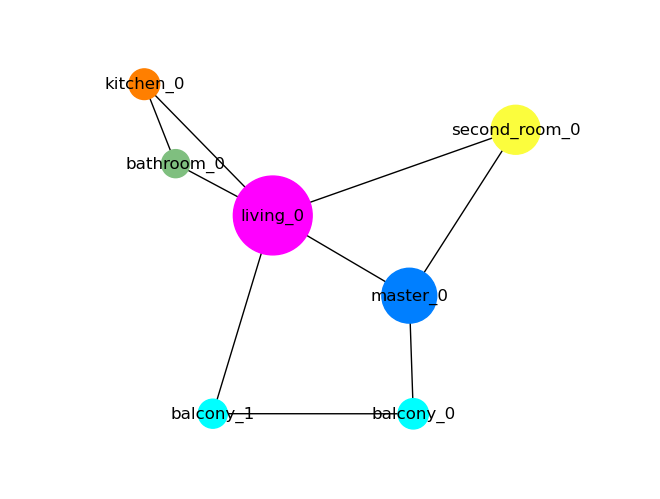

In [4]:
with open(url, 'rb') as f:
    Graphs = pickle.load(f)
    
G = Graphs[1911]
print(G)
draw_graph(G)

In [6]:
features = ['roomType_embd', 'actualCentroid_x', 'actualCentroid_y']

In [7]:
# Converting networkx graphs to pytorchGeo graphs
Graphs_pyTorch = []
for G in tqdm(Graphs):
    G_new = from_networkx(G, group_node_attrs=features, group_edge_attrs=['dist'])
    # Normalizing feature matrix (x)
    # G_new = T.NormalizeFeatures()(G_new)
    
    Graphs_pyTorch.append(G_new)

Graphs_pyTorch[0]

100%|███████████████████████████████████████████████████████████| 80788/80788 [00:44<00:00, 1831.27it/s]


Data(edge_index=[2, 12], roomType_name=[5], rec_w=[5], rec_h=[5], roomSize=[5], x=[5, 3], edge_attr=[12, 1])

> There are many types of `rooms` but we will give them a defualt number = 1.
> So, also we will decrease the embedings to be between 0:6

In [10]:
print(f'Befor: G_1 embedings are: {Graphs_pyTorch[1].x}')
for G in tqdm(Graphs_pyTorch, total=len(Graphs_pyTorch)):
    for j ,value in enumerate(G.x):
        type_ = int(value[0].item())
        
        if type_ in [1, 4, 5, 6, 7, 8]:
            G.x[j][0] = 1
        
        # making all labels from 0 to 6 only to help one_hotting
        elif type_ == 9:
            G.x[j][0] = 4
        elif type_ == 10:
            G.x[j][0] = 5
        elif type_ == 11:
            G.x[j][0] = 6
print(f'After: G_1 embedings are: {Graphs_pyTorch[1].x}')

Befor: G_1 embedings are: tensor([[  0.0000, 126.9323, 119.2773],
        [  1.0000, 116.0000, 197.5000],
        [  2.0000, 179.0000,  42.0000],
        [  3.0000, 206.9337,  78.3202],
        [  7.0000,  80.5000,  75.5000],
        [  7.0000, 127.6623,  55.4979],
        [  9.0000,  44.5000, 134.5000],
        [ 10.0000, 138.5000,  92.5000]])


100%|██████████████████████████████████████████████████████████| 80788/80788 [00:05<00:00, 14470.57it/s]

After: G_1 embedings are: tensor([[  0.0000, 126.9323, 119.2773],
        [  1.0000, 116.0000, 197.5000],
        [  2.0000, 179.0000,  42.0000],
        [  3.0000, 206.9337,  78.3202],
        [  1.0000,  80.5000,  75.5000],
        [  1.0000, 127.6623,  55.4979],
        [  4.0000,  44.5000, 134.5000],
        [  5.0000, 138.5000,  92.5000]])


> If we need to creat graphs with padding by the maximum number of nodes.

In [13]:
# # but we need to do some padding to our graphs to be all of the same number of nodes.
# padded_graphs = []
# for G in Graphs_pyTorch:
#     x          = G.x
#     y          = G.roomType_embd
#     edge_index = G.edge_index
#     edge_attr  = G.edge_attr
    
#     nu_nodes = x.shape[0]

#     padded_x = torch.nn.functional.pad(x, pad=(0, 0, 0, 8 - nu_nodes), mode='constant', value=0)
#     padded_y = torch.nn.functional.pad(y, pad=(0, 8 - nu_nodes), mode='constant', value=0)
#     train_mask   = torch.ones(nu_nodes)
#     train_mask   = torch.nn.functional.pad(train_mask, pad=(0, 8 - nu_nodes), mode='constant', value=0).to(bool)

#     data = Data(x = padded_x, y = padded_y, edge_index= G.edge_index, edge_attr = G.edge_attr, train_mask=train_mask)

#     padded_graphs.append(data)

# padded_graphs[0]

<a id='model'></a>
## GNN Model

<a id='dataLoader'></a>
### Data Loader

In [196]:
class Planify_Dataset(Dataset):
    def __init__(self, data):
        self.Graphs = data
    
    def __len__(self):
        return len(self.Graphs)

    def __getitem__(self, index):
        G = self.Graphs[index].clone().to(device)
        # shuffling nodes inside the same graph
        permutation = torch.randperm(G.num_nodes).to(device)
        
        G.x = G.x[permutation]
        G.edge_index = permutation[G.edge_index]
        G.rec_w = G.rec_w[permutation]
        G.rec_h = G.rec_h[permutation]
        # padded_x = torch.nn.functional.pad(x, pad=(0, 0, 0, 8 - nu_nodes), mode='constant', value=0)
        # padded_y = torch.nn.functional.pad(y, pad=(0, 8 - nu_nodes), mode='constant', value=0)
        
        return G

In [197]:
# There is a problem here, the first graph has this problem on my device [windows]

batch_size = 128
dataset = Planify_Dataset(Graphs_pyTorch[:10000])
loader  = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [198]:
# Saving model function
import os

# checkpoint_dir = '/kaggle/working/checkpoints'
# checkpoint_dir = '/media/mo/DATA/Grad/Planify_Dataset/Graph/checkpoints'
checkpoint_dir = "./checkpoints"

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    

def save_checkpoint(model, optimizer, epoch):
    checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pt')
    # Saving model each 15 epochs
    if epoch % 20 == 0:
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch
        }, checkpoint_path)
        
        print('Model saved :)')

<a id='archi'></a>
### Architecture

In [224]:
class GNN(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, nu_classes):
        super().__init__()
        self.gc1 = GATConv(input_channels, hidden_channels, heads=8)
        self.gc2 = GATConv(hidden_channels * 8, hidden_channels * 8, heads=8)
        self.gc3 = GATConv(hidden_channels * 8 * 8, hidden_channels * 8, heads=8)
        
        self.fc1 = nn.Linear(hidden_channels * 8 * 8, hidden_channels * 8)
        self.fc2 = nn.Linear(hidden_channels * 8, hidden_channels)
        self.fc3 = nn.Linear(hidden_channels, hidden_channels)
        self.regreetor = nn.Linear(hidden_channels, 1)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.gc1(x, edge_index)
        x = x.relu()
        # x = F.dropout(x, training=self.training)
        
        print(x.shape)
        
        x = self.gc2(x, edge_index)
        x = x.relu()
        # x = F.dropout(x, training=self.training)
        
        x = self.gc3(x, edge_index)
        x = x.relu()
        
        x = self.fc1(x)
        x = x.relu()
        
        x = self.fc2(x)
        x = x.relu()
        
        x = self.fc3(x)
        x = x.relu()
        
        # Reshape x to (batch_size, 4)
        # x = x.view(-1, 4) 
        
        x = self.regreetor(x)
        x = x.relu()

        return x


nu_features    = Graphs_pyTorch[0].x.shape[1]

model = GCN(nu_features, hidden_channels=8, nu_classes=number_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


# to monitor the loss & accuracy.
errors = []
acc = []

model

GCN(
  (gc1): GATConv(3, 8, heads=8)
  (gc2): GATConv(64, 64, heads=8)
  (gc3): GATConv(512, 64, heads=8)
  (fc1): Linear(in_features=512, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=8, bias=True)
  (regreetor): Linear(in_features=8, out_features=1, bias=True)
)

In [225]:
# Hyperparameters
learning_rate = 0.1
nu_epochs = 10

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.972)

# def scheduler(epoch, lr)
#     if epoch < 20:
#         return lr
#     else:
#         return lr * 0.99

<a id='train'></a>
### Training


In [227]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the model
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        out = self.linear(x)
        return out

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Prepare the data
x = torch.randn(100, 1)
y = 2*x + 1

# Define the model and train it
model = LinearRegression(1, 1)

for epoch in range(1000):
    # Forward pass
    y_pred = model(x)
    
    # Compute loss
    loss = criterion(y_pred, y)
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print progress
    if (epoch+1) % 100 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 1000, loss.item()))

# Use the trained model to make predictions
x_test = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])
y_test_pred = model(x_test.unsqueeze(1))

print('Predictions:', y_test_pred)

Epoch [100/1000], Loss: 3.4725
Epoch [200/1000], Loss: 3.4725
Epoch [300/1000], Loss: 3.4725
Epoch [400/1000], Loss: 3.4725
Epoch [500/1000], Loss: 3.4725
Epoch [600/1000], Loss: 3.4725
Epoch [700/1000], Loss: 3.4725
Epoch [800/1000], Loss: 3.4725
Epoch [900/1000], Loss: 3.4725
Epoch [1000/1000], Loss: 3.4725
Predictions: tensor([[0.2879],
        [0.9874],
        [1.6870],
        [2.3866],
        [3.0861]], grad_fn=<AddmmBackward0>)


In [226]:
for epoch in range(nu_epochs):
    running_loss = 0.0
    train_acc    = 0.0
    for i, data in tqdm(enumerate(loader), desc='Planifying', total=len(loader)):
        optimizer.zero_grad()
        # Forward pass
        logits    = model(data).reshape(-1)
        # computing loss through crossEntropy loss function
        targets = data.roomSize
        loss = criterion(logits, targets)

        # Backward pass
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        # current_lr = optimizer.param_groups[0]['lr']
        # optimizer = torch.optim.Adam(model.parameters(), lr=scheduler(epoch, current_lr))
        
        # Monitoring
        running_loss += loss.item()
        # train_acc += (torch.argmax(logits, 1).flatten() == data.roomType_embd).type(torch.float).mean().item()
        lr = optimizer.param_groups[0]['lr']
    
    # model.regreetor.reset_parameters()
    
    print(targets[:5])
    print(logits[:5])
    
    errors.append(running_loss/batch_size)
    # acc.append(train_acc/batch_size)
    
    # Updating scheduler each 15 epochs.
    scheduler.step()
    
    # Saving the model.
    save_checkpoint(model, optimizer, epoch)
    
    # Monitoring and printing.
    batch_size = len(loader)
    print(f'Epoch: {epoch + 1}/{nu_epochs} | lr: {lr} | avg_loss: {running_loss/batch_size:.5f}')

Planifying: 100%|███████████████████████████████████████████████████████| 79/79 [00:08<00:00,  8.90it/s]


tensor([0.3703, 0.1385, 0.1043, 0.0388, 0.0578], device='cuda:0')
tensor([0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SliceBackward0>)
Model saved :)
Epoch: 1/10 | lr: 0.1 | avg_loss: 0.02993


Planifying:  27%|██████████████▌                                        | 21/79 [00:02<00:06,  9.42it/s]


KeyboardInterrupt: 

In [ ]:
# plt.plot(errors);
plt.plot(acc, label='accuracy');
plt.plot(errors, label='error');
plt.xlabel('Epochs')
plt.title('Monitoring the model')
plt.legend();

> Testing random graphs

In [219]:
idx = random.randint(0, len(Graphs_pyTorch))
G = Graphs_pyTorch[idx].to(device)
logits = model(G).reshape(-1)
# predicts = torch.argmax(logits, 1)

print(f'The real values: {G.roomSize}')
print(f'Predicted values: {logits}')

The real values: tensor([0.4887, 0.1580, 0.0555, 0.1259, 0.1343, 0.0498], device='cuda:0')
Predicted values: tensor([0.9583, 1.0073, 0.9963, 0.9613, 0.9870, 0.9559], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)
